<a href="https://colab.research.google.com/github/kevinhuang8423/alpha_camp_HW/blob/main/Content_based_%E4%BD%9C%E6%A5%AD_W2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [ ]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [ ]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

In [ ]:
# metadata = getDF('/content/meta_All_Beauty.json.gz')
# ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata = getDF('./meta_All_Beauty.json.gz')
ratings = pd.read_csv('./All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]


In [ ]:
ratings.head(3)

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800


## 資料預覽

In [ ]:
##去除重複資料
metadata = metadata.loc[metadata.astype(str).drop_duplicates().index]

In [ ]:
metadata.shape

(32488, 19)

In [ ]:
type(metadata['price'].iloc[2])

str

In [ ]:
metadata['main_cat'].unique()

array(['All Beauty'], dtype=object)

<AxesSubplot:>

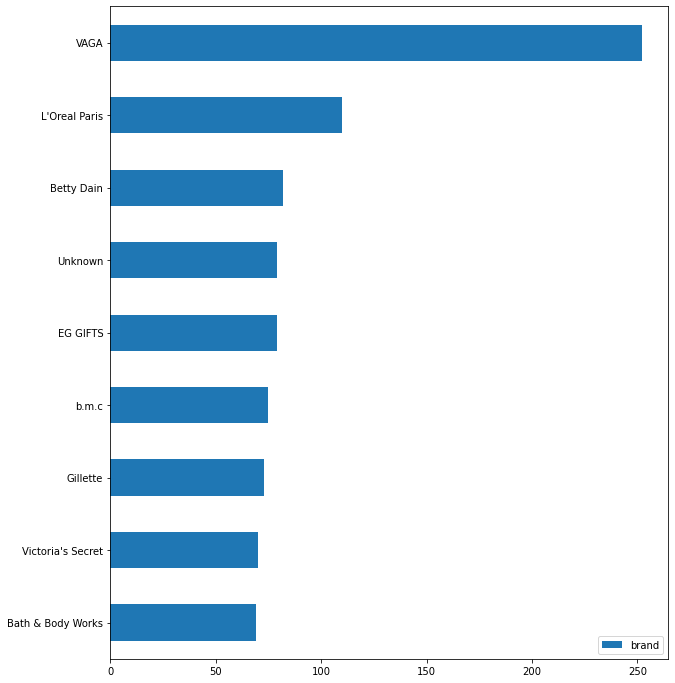

In [ ]:
metadata['brand'].value_counts(ascending=True).iloc[-10:-1].to_frame().plot(kind='barh',figsize=(10,12))

 Beauty  Personal Care       32015
 Grocery  Gourmet Food          37
 Health  Household              21
 Toys  Games                     3
 Sports  Outdoors                3
 Cloth                           2
 Baby                            2
 Tools  Home Improvement         1
 Automotive                      1
 Home  Kitchen                   1
Name: Sub_type, dtype: int64

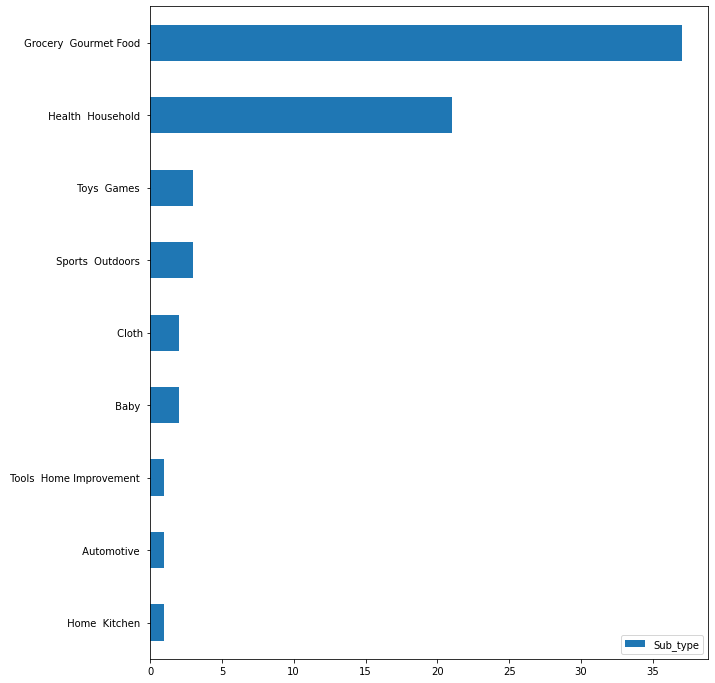

In [ ]:
metadata['Sub_type'] = metadata['rank'].str.split('in').str[1]
metadata['Sub_type'] = metadata['Sub_type'].str.replace(r'(','', regex=True)
metadata['Sub_type'] = metadata['Sub_type'].str.replace(r'&.*;','', regex=True)
metadata['Sub_type'] = metadata['Sub_type'].str.replace(r'&','', regex=True)
metadata['Sub_type'].value_counts(ascending=True).iloc[-10:-1].to_frame().plot(kind='barh',figsize=(10,12))
metadata['Sub_type'].value_counts()

## 資料整理

In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [ ]:
# 合併 title/brand/Sub_type 同時提取特徵值
def words_combine(x):
#     words = f'{x["Sub_type"]}, {"".join(x["title"])}, {"".join(str(x["brand"]))} '
    words = f'{"".join(x["title"])}, {"".join((x["description"]))} '
    words = words.replace('(','').replace(')','').replace('&','').replace('/','').replace(';','').replace(',','')
    words = words.lower()

    return words

In [ ]:
metadata['All_feature'] = metadata.apply(words_combine, axis =1)
metadata['All_feature'].head(10)

0    loud 'n cleartrade personal sound amplifier lo...
1    no7 lift amp luminate triple action serum 50ml...
2    no7 stay perfect foundation cool vanilla by no...
3    wella koleston perfect hair colour 4444 medium...
4    lacto calamine skin balance oil control 120 ml...
5    mary kay satin hands hand cream travel mini si...
6    unique custom cast iron liner shader tattoo ma...
7    imagen bendita por su santidad our lady of cha...
8    mali princ novi prevod proslavljene knjige zad...
9    moleskine payne's grey card wallet moleskine n...
Name: All_feature, dtype: object

In [ ]:
metadata['All_feature'].loc[1]

'no7 lift amp luminate triple action serum 50ml by boots no7 lift  luminate triple action serum 50ml by boots '

## 資料切分

In [ ]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
#近一個月的銷售熱度_By product sales
ratings_trainings_L1M = ratings[
    (ratings['DATE'] >= '2018-08-01')& 
    (ratings['DATE'] <= '2018-08-31')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records') #‘records’ : list like [{column -> value}, … , {column -> value}]
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [ ]:
metadata.shape

(32488, 21)

## 產生推薦

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 計算商品用標題所表示的 tfidf 矩陣
metadata = metadata.drop_duplicates('All_feature')

metadata.reset_index(inplace=True, drop=True)



In [ ]:
tf = TfidfVectorizer(analyzer='word', max_df= 100)
tfidf_matrix = tf.fit_transform(metadata['All_feature'])

In [ ]:
# 計算商品間的相似程度
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
mapping = pd.Series(metadata.index,index = metadata['All_feature'])


In [ ]:
# 每個商品回傳 k 個最相近的商品
def recommend_item(all_feature, k=2):
    try:
        item_index = mapping[all_feature]
#         print(item_index)
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
#         print(metadata['asin'].iloc[item_indices].tolist())
        return (metadata['asin'].iloc[item_indices].tolist())
    except:
        return []

# 針對先前無購買資料的用戶，直接推薦近一個月熱銷前10名的商品
def rule_base_recom(ratings_trainings_L1M):
    training_data_groupby = ratings_trainings_L1M.groupby(['asin'], as_index=False).agg(sales_count=("asin", 'count'))
    training_data_groupby_sort = training_data_groupby.sort_values(by='sales_count',ascending=False)
    top10_recom = training_data_groupby_sort['asin'].to_list()[:10]
    return top10_recom



# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):   
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    if res == []:
        top10_recom = rule_base_recom(ratings_trainings_L1M)
        res.extend(top10_recom)
        return res
    else:
        return res

In [ ]:
def recommender(ratings_trainings, users=[], k=10):
    
    recommendations = {}
    '''
    content-based
    '''
    
    recommendations = {user: recommend_items(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]
              ['asin'].tolist())]['All_feature'].tolist(), 10) for user in users}
    return recommendations

ratings_by_user = recommender(ratings_trainings, users)


## 結果評估

In [ ]:
def evaluate(ratings_by_user, ratings_testings_by_user):

    total = 0
    for d in ratings_by_user:
        if d in ratings_testings_by_user:
            total += len(set(ratings_testings_by_user[d]) & set(ratings_by_user[d]))
    score = total / len(ratings_testings)
    return score

evaluate(ratings_by_user, ratings_testings_by_user)

0.15254237288135594